In [1]:
import os
import requests
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown
from dotenv import load_dotenv

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.messages import HumanMessage
from langchain.vectorstores import FAISS
from langchain.schema.document import Document
from langchain_text_splitters import CharacterTextSplitter
from langchain_community.document_loaders import TextLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [2]:
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Get the API key
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

# Debug: Check if the API key is loaded
if GOOGLE_API_KEY is None:
    print("Error: GOOGLE_API_KEY is not set. Check your .env file or environment variables.")
else:
    print("GOOGLE_API_KEY loaded successfully.")


GOOGLE_API_KEY loaded successfully.


In [3]:
# Function to load Gemini model
def load_model(model_name):
    return ChatGoogleGenerativeAI(model=model_name)

In [4]:
# Load text-based model
model_text = load_model("gemini-pro")

In [5]:
# Test model response
print(model_text.invoke("Please come up with the best funny line.").content)

"I'm so good at multitasking, I can procrastinate two things at once!"


In [6]:
# Function to download and show an image
def get_image(url, filename, extension):
    content = requests.get(url).content
    filepath = f"{filename}.{extension}"
    with open(filepath, 'wb') as f:
        f.write(content)
    image = Image.open(filepath)
    image.show()
    return image


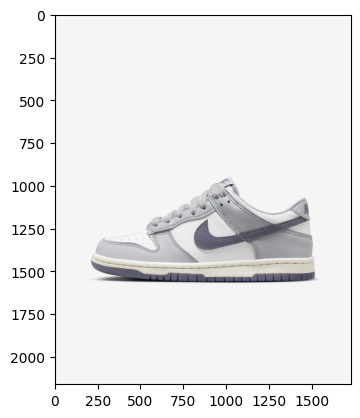

In [7]:
# Download and display an image
image_url = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/1705ca64-fbc8-4b79-a451-4ab77760c219/dunk-low-older-shoes-C7T1cx.png"
image = get_image(image_url, "nike-shoes", "png")

plt.imshow(image)
plt.show()


In [8]:
# Load vision model
vision_model = load_model("models/gemini-2.0-flash")

In [9]:
# Encode image to base64 for Gemini vision model
def encode_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return f"data:image/png;base64,{base64.b64encode(buffered.getvalue()).decode()}"

encoded_image = encode_image_to_base64(image)

In [10]:

# Image analysis prompt
prompt = "Give me a summary of this image in 5 words."

message = HumanMessage(
    content=[
        {"type": "text", "text": prompt},
        {"type": "image_url", "image_url": encoded_image},
    ]
)

In [11]:
# Get vision model response
print(vision_model.invoke([message]).content)

Gray and white Nike shoe


In [12]:
# Load and process text file
loader = TextLoader("Nike_shoes.txt")
text = loader.load()[0].page_content

In [13]:
# Function to split text into chunks
def get_text_chunks(text):
    text_splitter = CharacterTextSplitter(chunk_size=100, chunk_overlap=20)
    docs = [Document(page_content=chunk) for chunk in text_splitter.split_text(text)]
    return docs

docs = get_text_chunks(text)

Created a chunk of size 514, which is longer than the specified 100
Created a chunk of size 389, which is longer than the specified 100
Created a chunk of size 230, which is longer than the specified 100
Created a chunk of size 292, which is longer than the specified 100
Created a chunk of size 248, which is longer than the specified 100
Created a chunk of size 692, which is longer than the specified 100
Created a chunk of size 161, which is longer than the specified 100
Created a chunk of size 483, which is longer than the specified 100
Created a chunk of size 133, which is longer than the specified 100
Created a chunk of size 600, which is longer than the specified 100
Created a chunk of size 177, which is longer than the specified 100


In [14]:
# Create FAISS vector store with Google Generative AI embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever()

In [15]:
# Retrieve information
retrieved_docs = retriever.invoke("History of Nike Shoes?")
print(retrieved_docs)

[Document(id='f561d294-8bcc-41d5-9982-4103b804f3dd', metadata={}, page_content='---\n\n## **History of Nike Shoes**'), Document(id='7d15546c-ad65-4333-a328-3795a94cef35', metadata={}, page_content='### **Summary and History of Nike Shoes**'), Document(id='45ad699c-bd8c-4d29-bf97-6a989c37e6f8', metadata={}, page_content="### **1. The Early Years (1964–1971): Blue Ribbon Sports**\nNike's origins date back to 1964 when **Bill Bowerman**, a track and field coach at the University of Oregon, and his former student **Phil Knight** founded *Blue Ribbon Sports (BRS)*. Initially, BRS functioned as a distributor for **Onitsuka Tiger (now ASICS)**, a Japanese shoe company, selling their running shoes in the U.S."), Document(id='fdc4f0db-a8a5-41b0-a9aa-95c688caa3f9', metadata={}, page_content='Throughout the 1970s, Nike gained popularity among athletes, thanks to innovations such as **waffle soles**, which provided better traction. By 1978, Nike introduced its first **Air technology** shoes, layin

In [16]:
# Load new Gemini models
llm_text = load_model("models/gemini-2.0-flash")
llm_vision = load_model("Gemini 1.5 Flash")

In [17]:
# Define RAG prompt template
template = """
{query}
Provide brief information and store location.
"""

In [18]:
prompt = ChatPromptTemplate.from_template(template)

In [19]:
# RAG chain
rag_chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt
    | llm_text
    | StrOutputParser()
)

In [20]:
# Test RAG chain
result = rag_chain.invoke("Can you give me details of Nike sandals?")
display(Markdown(result))

Okay, let's break down Nike sandals, covering some popular models, their general features, and how to find them in stores.

**General Features of Nike Sandals:**

*   **Sporty Aesthetic:** Nike sandals typically have a sporty, athletic-inspired look. They often incorporate elements of Nike's footwear design language.
*   **Comfort Focus:** Designed for casual wear, post-workout recovery, or warm weather, comfort is a key consideration. They often feature cushioned footbeds and soft straps.
*   **Durable Materials:** Nike uses a range of materials, including synthetic leather, foam, and rubber, chosen for their durability and water resistance.
*   **Variety of Styles:**  Nike offers a range of sandal styles, from slides to flip-flops to more supportive, adjustable sandals.
*   **Nike Branding:**  The iconic Nike swoosh is usually prominently displayed.

**Popular Nike Sandal Models (Examples):**

*   **Nike Benassi JDI Slide:**
    *   **Description:** A classic, one-piece slide sandal. Features a cushioned footbed and a synthetic leather strap with the Nike logo.
    *   **Best For:**  Casual wear, post-exercise recovery, pool or beach.
*   **Nike Victori One Slide:**
    *   **Description:** An updated version of the Benassi, often with a softer foam and a more comfortable strap.
    *   **Best For:** Similar to the Benassi, everyday casual wear.
*   **Nike On Deck Flip Flop:**
    *   **Description:** A simple and comfortable flip-flop design, great for warm weather.
    *   **Best For:** Warm weather and casual wear.
*   **Nike Canyon Sandal:**
    *   **Description:** A more rugged, adjustable sandal with multiple straps and a durable outsole.  Designed for light hiking and outdoor activities.
    *   **Best For:** Light outdoor adventures, walking, more support than a slide.
*   **Nike Offline Slide:**
    *   **Description:** A more unique and fashion-forward slide, sometimes featuring interesting textures, materials, and a focus on relaxation.
    *   **Best For:** Style-conscious casual wear, recovery.

**Where to Buy Nike Sandals (Store Locations):**

*   **Nike Stores:**  These are the most obvious place to find a wide selection of Nike sandals.  You can find store locations on the Nike website ([nike.com](https://nike.com)). Use the "Find a Store" feature.
*   **Nike Outlet Stores:** Often have discounted Nike sandals, including older models.
*   **Foot Locker:** A major retailer that carries a large selection of Nike footwear, including sandals. Check their website ([footlocker.com](https://footlocker.com)) for locations.
*   **Champs Sports:** Another athletic footwear retailer that carries Nike sandals.
*   **Dick's Sporting Goods:** Carries a range of Nike athletic apparel and footwear, including some sandal models.
*   **Department Stores:**  Stores like Macy's, Nordstrom, and others may carry a selection of Nike sandals, especially during the spring and summer seasons.
*   **Online Retailers:**
    *   **Nike.com:** The official Nike website is a great place to browse the entire sandal collection.
    *   **Amazon:**  Often has a wide variety of Nike sandals available.
    *   **Zappos:** Known for its excellent customer service and wide selection of shoes.
    *   **Other Online Retailers:** Check sites like ASOS, Finish Line, and others that sell athletic footwear.

**Tips for Finding Sandals in Stores:**

*   **Check online stock:** Before visiting a store, check the retailer's website to see if the sandal you're looking for is in stock at your local store.
*   **Call ahead:** If you're unsure, call the store to confirm they have the style and size you need.
*   **Consider the season:** Selection may be limited during the off-season (fall/winter).
*   **Read reviews:** Before purchasing, read online reviews to get an idea of the sandal's comfort, fit, and durability.

**To get more specific information, please tell me:**

*   **What type of activity will you be using the sandals for?** (e.g., casual wear, hiking, post-workout)
*   **Do you have any specific features in mind?** (e.g., arch support, adjustable straps, waterproof)
*   **What is your budget?**
*   **What country/region are you located in?** (This will help me provide accurate store location information.)

I can then give you more targeted recommendations.

In [21]:
# Full multimodal chain
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

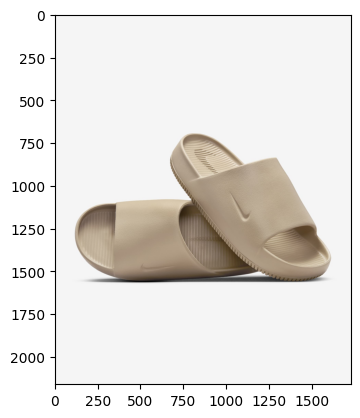

In [22]:
# Download another image for testing
url_1 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/252f2db6-d426-4931-80a0-8b7f8f875536/calm-slides-K7mr3W.png"
image = get_image(url_1, "nike-sandals", "png")

plt.imshow(image)
plt.show()

In [23]:
# Encode new image
encoded_image = encode_image_to_base64(image)

In [24]:
# Send image query to full_chain
message = HumanMessage(
    content=[
        {"type": "text", "text": "Provide information on this sandal image Brand and model."},
        {"type": "image_url", "image_url": encoded_image},
    ]
)

In [26]:
# Get final response
#result = full_chain.invoke([message])
#display(Markdown(result))

In [27]:
print("The End")

The End
